# Install modules


In [117]:
%pip install --upgrade pip
%pip install fasttext
%pip install imblearn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install scikit-learn
%pip install seaborn
%pip install tensorflow[and-cuda]

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.
Defaulting to 

## Models


In [1]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
df = pd.read_csv("data/clean.csv")


def show_eval(model, X_train, X_val, y_train, y_val):
    print(f"Train accuracy: {model.score(X_train, y_train) * 100:.3f}%")
    print(f"Test accuracy: {model.score(X_val, y_val) * 100:.3f}%")

    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d")
    plt.show()


def transform_oversample(encoder, X, y, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)

    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return X_train, X_val, y_train, y_val

### Logistic Regression


In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

# Bag of words
cv = CountVectorizer(strip_accents="unicode", stop_words="english")
X_train, X_val, y_train, y_val = transform_oversample(cv, df["text"], df["label"])

/home/kayu/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


/home/kayu/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/kayu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kayu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/kayu/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was 

Train accuracy: 92.264%
Test accuracy: 75.435%
              precision    recall  f1-score   support

           0       0.62      0.69      0.65      2030
           1       0.83      0.79      0.81      4003

    accuracy                           0.75      6033
   macro avg       0.73      0.74      0.73      6033
weighted avg       0.76      0.75      0.76      6033



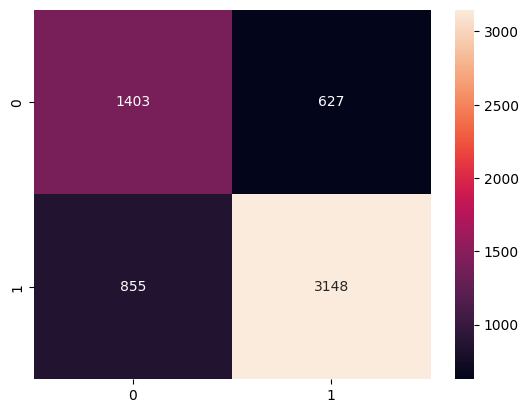

In [96]:
# Logistic regression model
lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid={
        "C": np.logspace(-3, 3, 7),
        "solver": ["newton-cg", "lbfgs", "saga"],
    },
    n_jobs=8,
    cv=3,
)
lr.fit(X_train, y_train)

show_eval(lr, X_train, X_val, y_train, y_val)

### Naive Bayes


In [97]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag of n-grams
cv = CountVectorizer(
    strip_accents="unicode",
    stop_words="english",
    ngram_range=(1, 2),
    max_features=40000,
)
X_train, X_val, y_train, y_val = transform_oversample(cv, df["text"], df["label"])

/home/kayu/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Train accuracy: 87.112%
Test accuracy: 76.612%
              precision    recall  f1-score   support

           0       0.65      0.66      0.66      2028
           1       0.83      0.82      0.82      4005

    accuracy                           0.77      6033
   macro avg       0.74      0.74      0.74      6033
weighted avg       0.77      0.77      0.77      6033



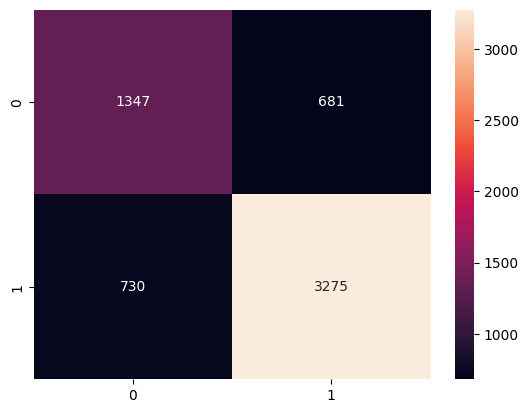

In [98]:
from sklearn.naive_bayes import MultinomialNB

# Multinomial Naive Bayes model
MNB = GridSearchCV(
    MultinomialNB(),
    param_grid={"alpha": np.linspace(0.1, 1, 10)},
    n_jobs=8,
)
MNB.fit(X_train, y_train)

show_eval(MNB, X_train, X_val, y_train, y_val)

### Support Vector Classification


In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfv = TfidfVectorizer(
    strip_accents="unicode",
    stop_words="english",
    ngram_range=(1, 2),
    max_features=10000,
)
X_train, X_val, y_train, y_val = transform_oversample(tfv, df["text"], df["label"])

/home/kayu/.local/lib/python3.10/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7f42c0c6f400>
Traceback (most recent call last):
  File "/home/kayu/.local/lib/python3.10/site-packages/threadpoolctl.py", line 847, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/home/kayu/.local/lib/python3.10/site-packages/threadpoolctl.py", line 984, in _make_controller_from_path
    lib_controller = controller_class(filepath=filepath, prefix=prefix)
  File "/home/kayu/.local/lib/python3.10/site-packages/threadpoolctl.py", line 111, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/

/home/kayu/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/kayu/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/kayu/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/kayu/.local/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/kayu/.local/lib/python3.10/site-packag

Train accuracy: 93.797%
Test accuracy: 78.518%
              precision    recall  f1-score   support

           0       0.67      0.72      0.70      2062
           1       0.85      0.82      0.83      3971

    accuracy                           0.79      6033
   macro avg       0.76      0.77      0.77      6033
weighted avg       0.79      0.79      0.79      6033



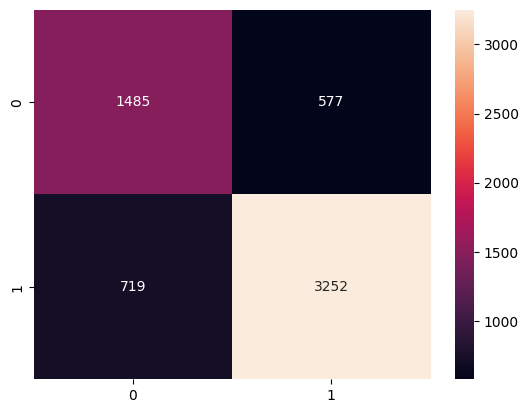

In [100]:
from sklearn.svm import LinearSVC

# Linear SVC model
linearSVC = GridSearchCV(
    LinearSVC(),
    param_grid={"loss": ["squared_hinge", "hinge"], "C": np.logspace(-3, 3, 7)},
    n_jobs=8,
    cv=3,
)
linearSVC.fit(X_train, y_train)

show_eval(linearSVC, X_train, X_val, y_train, y_val)

### FastText


In [95]:
# Format dataset for fasttext
df_fasttext = "__label__" + df["label"].astype(str) + " " + df["text"]
train, test = train_test_split(df_fasttext, test_size=0.2)
train.to_csv("data/fasttext.train", index=False, header=False)

Read 2M words
Number of words:  22779
Number of labels: 2
Progress: 100.0% words/sec/thread: 2227859 lr:  0.000000 avg.loss:  0.357475 ETA:   0h 0m 0s


Train accuracy: 88.064%
Test accuracy: 80.623%
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      2052
           1       0.84      0.87      0.86      3981

    accuracy                           0.81      6033
   macro avg       0.79      0.78      0.78      6033
weighted avg       0.80      0.81      0.80      6033



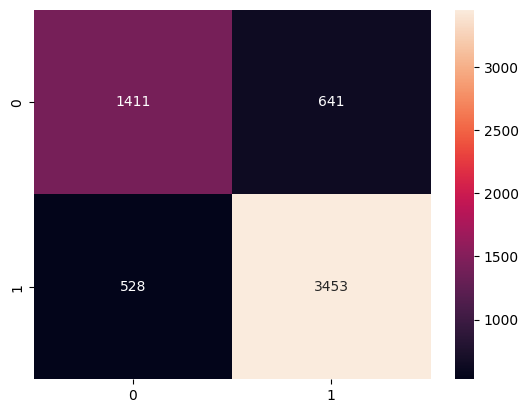

In [96]:
import fasttext

# Fasttext model
ft = fasttext.train_supervised(input="data/fasttext.train", epoch=20)

# Add methods so that show_eval can be used
ft.ft_predict = ft.predict
ft.predict = lambda X: list(
    map(lambda s: int(s[0].replace("__label__", "")), ft.ft_predict(X.to_list())[0])
)
ft.score = lambda X, y: np.mean(ft.predict(X) == y)

# Convert datasets to format that the graphing functions can use
train = train.str.replace("__label__", "", 1)
train = train.apply(lambda s: s.split(" ", 1))
X_train = pd.Series(map(lambda s: s[1], train))
y_train = pd.Series(map(lambda s: int(s[0]), train))

test = test.str.replace("__label__", "", 1)
test = test.apply(lambda s: s.split(" ", 1))
X_test = pd.Series(map(lambda s: s[1], test))
y_test = pd.Series(map(lambda s: int(s[0]), test))

show_eval(ft, X_train, X_test, y_train, y_test)

### LSTM


In [3]:
import tensorflow as tf

# Only log errors
# tf.get_logger().setLevel("ERROR")

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    df["text"], df["label"], test_size=0.2
)

# Create datasets
BATCH_SIZE = 32
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Use class weights instead of oversampling
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
total = y_train.shape[0]

weight_neg = (1 / neg) * (total / 2.0)
weight_pos = (1 / pos) * (total / 2.0)
class_weights = {0: weight_neg, 1: weight_pos}

2023-12-15 01:28:28.738932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 01:28:28.738984: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 01:28:28.740071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 01:28:28.749122: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 01:28:30.131352: W tensorflow/compiler/tf2

Epoch 1/100


/home/kayu/.local/lib/python3.10/site-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


755/755 [==============================] - 34s 36ms/step - loss: 0.5780 - accuracy: 0.7178 - val_loss: 0.6215 - val_accuracy: 0.6939
Epoch 2/100
755/755 [==============================] - 25s 33ms/step - loss: 0.5192 - accuracy: 0.7697 - val_loss: 0.5739 - val_accuracy: 0.7257
Epoch 3/100
755/755 [==============================] - 25s 33ms/step - loss: 0.5081 - accuracy: 0.7711 - val_loss: 0.5482 - val_accuracy: 0.7398
Epoch 4/100
755/755 [==============================] - 26s 34ms/step - loss: 0.5042 - accuracy: 0.7728 - val_loss: 0.5495 - val_accuracy: 0.7376
Epoch 5/100
755/755 [==============================] - 26s 34ms/step - loss: 0.4984 - accuracy: 0.7757 - val_loss: 0.5303 - val_accuracy: 0.7550
Epoch 6/100
755/755 [==============================] - 25s 33ms/step - loss: 0.4933 - accuracy: 0.7779 - val_loss: 0.5202 - val_accuracy: 0.7658
Epoch 7/100
755/755 [==============================] - 24s 32ms/step - loss: 0.4900 - accuracy: 0.7801 - val_loss: 0.5357 - val_accuracy: 0.75

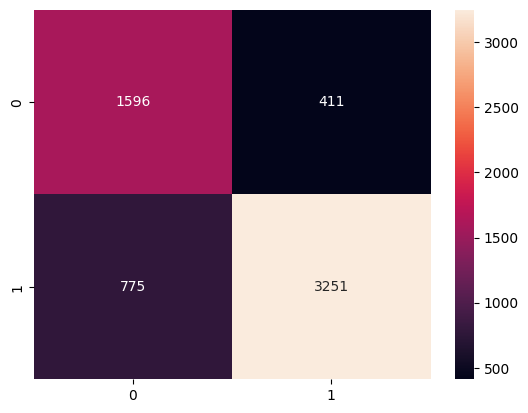

In [5]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import (
    TextVectorization,
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
)
from keras.regularizers import l2

# Text vectorization layer
lstm_vec_layer = TextVectorization(
    max_tokens=500, output_mode="int", output_sequence_length=500
)
lstm_vec_layer.adapt(X_train.values)

# LSTM model
lstm = Sequential(
    [
        lstm_vec_layer,
        Embedding(
            input_dim=len(lstm_vec_layer.get_vocabulary()),
            output_dim=128,
            embeddings_regularizer=l2(0.0005),
            mask_zero=True,
        ),
        Dense(128, activation="leaky_relu"),
        Dropout(0.3),
        Bidirectional(LSTM(64, kernel_regularizer=l2(0.0005))),
        Dense(64, activation="leaky_relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ]
)

lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Fit model
early_stopping = EarlyStopping(
    monitor="val_loss", patience=8, mode="min", restore_best_weights=True
)
lstm.fit(
    train_ds,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_ds,
    class_weight=class_weights,
)

# Add methods so that show_eval can be used
lstm.score = lambda X, y: lstm.evaluate(X.to_numpy(), y.to_numpy(), verbose=0)[1]
lstm.tf_predict = lstm.predict
lstm.predict = (
    lambda X: lstm.tf_predict(X.to_numpy(), verbose=0).flatten().round().astype(int)
)

print()
show_eval(lstm, X_train, X_val, y_train, y_val)

### Transformer


In [ ]:
import tensorflow as tf

# Only log errors
tf.get_logger().setLevel("ERROR")

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(
    df["text"], df["label"], test_size=0.2
)

# Create datasets
BATCH_SIZE = 32
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Use class weights instead of oversampling
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
total = y_train.shape[0]

weight_neg = (1 / neg) * (total / 2.0)
weight_pos = (1 / pos) * (total / 2.0)
class_weights = {0: weight_neg, 1: weight_pos}